In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pylab
import re
import csv
from IPython.display import display, HTML  # To display correct tables
from pprint import pprint
plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = (16.0, 8.0)
cp = sns.color_palette()



import os
os.chdir("../..")

from utils.gamesloader import Top14Loader

df = Top14Loader.get_consolidated_games()


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pylab
import re
import csv
from IPython.display import display, HTML  # To display correct tables
from pprint import pprint
plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = (16.0, 8.0)
cp = sns.color_palette()



import os
os.chdir("../..")

from utils.gamesloader import Top14Loader

df = Top14Loader.get_consolidated_games()

import pandas as pd

import numpy as np

q=np.log(10)/2000

def g(RD):
    return (1/np.sqrt(1+3*(q**2)*((RD)**2)/(np.pi)**2))

#rj est le rating de l'opposant et RDj le rating deviation de l'opposant

def E(r,rj,RDj):
    a=-g(RDj)*(r-rj)/400
    return (1/(1+10**a))

#Dans notre cas m=1 sur la somme, parce qu'il n'y a qu'un seul opposant chaque week-end

def D(RDj,r,rj):
    e=E(r,rj,RDj)
    f=(g(RDj))**2
    return 1/((q**2)*f*e*(1-e))

#sj est le résultat du match, sj=1 si victoire, 1/2 si nul et 0 si défaite

def newrating(r,rj,RD,RDj,sj):
    a=g(RD)
    b=E(r,rj,RDj)
    u=D(RDj,r,rj)
    return (r+(q/((1/(RD**2))+(1/u)))*a*(sj-b))    

#On calcule le nouveau RD en prenant en compte le fait que l'on a plus d'information grâce au match

def newratingdeviation(RD,RDj,r,rj):
    a=D(RDj,r,rj)
    return np.sqrt(1/((1/(RD**2))+(1/a)))
    

#Le RD est modifié chaque semaine à cause du temps qui passe et donc l'incertitude qui augmente. A chaque semaine
#passée, il faut actualiser le RD pour tenir compte du temps qui s'est écoulé

def timeratingdeviation(c,RD):
    return min(np.sqrt(RD**2+c**2),350)

def addratingseason(x,m): #x est la saison sur laquelle on veut ajouter le rating
    #m est le nombre de lignes cumulé des dataframes des saisons précédentes
    dfseason=df[df["season"]==x]
    lastgameplayed={} #on stocke dans ce dico en clé l'équipe et en valeur son dernier match joué
    currentrating={} #on stocke dans ce dico en clé l'équipe et en valeur son rating avant modification
    currentRD={} #on stocke dans ce dico en clé l'équipe et en valeur son RD avant modification
    dfseason=dfseason.sort_values("season_order")
    dfseason=dfseason.assign(rating_home_team=1500)
    dfseason=dfseason.assign(rating_away_team=1500)
    dfseason=dfseason.assign(RD_home_team=350)
    dfseason=dfseason.assign(RD_away_team=350)
    n=len(dfseason)
    i=0
    for index, row in dfseason.iterrows():
        sjh=0 #résultat du match pour l'équipe domicile
        if row["home_team"]>row["away_team"]:
            sjh=1
        elif row["home_team"]==row["away_team"]:
            sjh=1/2
        sja=1-sjh #résultat du match pour l'équipe extérieure
        rh=1500
        if row["home_team"] in currentrating:
            rh=currentrating.get(row["home_team"])
        ra=1500
        if row["away_team"] in currentrating:
            ra=currentrating.get(row["away_team"])
        RDh=350
        if row["home_team"] in currentRD:
            RDh=currentRD.get(row["home_team"])
        RDa=350
        if row["away_team"] in currentRD:
            RDa=currentRD.get(row["away_team"])
        timepassedhome=0
        timepassedaway=0
        timeRDh=RDh
        timeRDa=RDa
        c=60 #choix de la valeur de c
        if row["home_team"] in lastgameplayed: #on calcule l'intervalle de temps qui s'est écoulé depuis le dernier match
            d1=lastgameplayed.get(row["home_team"])
            d2=row["datetime"]
            timepassedhome=int((d2-d1).days/7)
            for l in range(timepassedhome):
                timeRDh=timeratingdeviation(c,timeRDh) #prise en compte de la modification du RD due au temps
        if row["away_team"] in lastgameplayed:
            d1=lastgameplayed.get(row["away_team"])
            d2=row["datetime"]
            timepassedaway=int((d2-d1).days/7)
            for l in range(timepassedaway):
                timeRDa=timeratingdeviation(c,timeRDa)
        newrh=newrating(rh,ra,timeRDh,timeRDa,sjh) #on effectue d'abord le changement de rating avant celui de RD
        newra=newrating(ra,rh,timeRDa,timeRDh,sja)
        newRDh=newratingdeviation(timeRDh,timeRDa,newrh,newra)
        newRDa=newratingdeviation(timeRDa,timeRDh,newra,newrh)
        j=n+m-i-2
        #on va chercher les équipes qui ont joué pour actualiser leur rating pour leurs prochains matchs
        while (j>=m+1) and dfseason.at[j,"home_team"]!=row["home_team"] and dfseason.at[j,"away_team"]!=row["home_team"]:
            j=j-1
        if j>=m:  
            if dfseason.at[j,"home_team"]==row["home_team"]:
                dfseason.at[j,"rating_home_team"]=newrh
                dfseason.at[j,"RD_home_team"]=newRDh
            elif dfseason.at[j,"away_team"]==row["home_team"]:
                dfseason.at[j,"rating_away_team"]=newrh
                dfseason.at[j,"RD_away_team"]=newRDh
        k=n+m-i-2
        while (k>=m+1) and dfseason.at[k,"home_team"]!=row["away_team"] and dfseason.at[k,"away_team"]!=row["away_team"]:
            k=k-1
        if k>=m:
            if dfseason.at[k,"home_team"]==row["away_team"]:
                dfseason.at[k,"rating_home_team"]=newra
                dfseason.at[k,"RD_home_team"]=newRDa
            elif dfseason.at[k,"away_team"]==row["away_team"]:
                dfseason.at[k,"rating_away_team"]=newra
                dfseason.at[k,"RD_away_team"]=newRDa
        currentrating[row["home_team"]]=newrh
        currentrating[row["away_team"]]=newra
        currentRD[row["home_team"]]=newRDh
        currentRD[row["away_team"]]=newRDa
        lastgameplayed[row["home_team"]]=row["datetime"]
        lastgameplayed[row["away_team"]]=row["datetime"]
        i=i+1
    return dfseason

#on crée un nouveau dataframe où on ajoute les rating des équipes sur toutes les saisons
df_with_ratings=addratingseason(2009,0)
a=len(addratingseason(2009,0))
for l in range(1,9): #9 est le nombre de saisons auquel on a accès
    U=addratingseason(2009+l,a)
    f=[df_with_ratings,U]
    a+=len(U)
    df_with_ratings=pd.concat(f)
df_with_ratings

season_order               home_team               away_team  \
185              0           USA Perpignan        Aviron Bayonnais   
184              1               Montauban        Stade Toulousain   
183              2           RC Toulonnais    Stade Francais Paris   
182              3     CS Bourgoin Jallieu                Clermont   
181              4                CA Brive  Montpellier Herault RC   
180              5      Biarritz Olympique       Castres Olympique   
179              6                    Albi               Racing 92   
178              7        Aviron Bayonnais    Stade Francais Paris   
177              8        Stade Toulousain                CA Brive   
176              9  Montpellier Herault RC           USA Perpignan   
175             10                Clermont               Montauban   
174             11      Biarritz Olympique                    Albi   
173             12           RC Toulonnais               Racing 92   
172             13       Castres Olympique     CS Bourgoin Jallieu   
171             14                CA Brive                Clermont   
170             15    Stade Francais Paris  Montpellier Herault RC   
169             16               Racing 92        Aviron Bayonnais   
168             17           USA Perpignan        Stade Toulousain   
167             18     CS Bourgoin Jallieu      Biarritz Olympique   
166             19                    Albi           RC Toulonnais   
165             20           USA Perpignan                CA Brive   
164             21        Stade Toulousain        Aviron Bayonnais   
163             22    Stade Francais Paris               Montauban   
162             23           RC Toulonnais                Clermont   
161             24  Montpellier Herault RC      Biarritz Olympique   
160             25     CS Bourgoin Jallieu               Racing 92   
159             26               Montauban           RC Toulonnais   
158             27               Racing 92           USA Perpignan   
157             28       Castres Olympique  Montpellier Herault RC   
156             29                CA Brive                    Albi   
...            ...                     ...                     ...   
1524           158                    Agen  Union Sportive Oyonnax   
1523           159  Montpellier Herault RC             La Rochelle   
1522           160               Racing 92           RC Toulonnais   
1521           161           RC Toulonnais  Montpellier Herault RC   
1520           162  Union Sportive Oyonnax                CA Brive   
1519           163         Section Paloise                    Agen   
1518           164                Clermont         Bordeaux Begles   
1517           165                    Lyon    Stade Francais Paris   
1516           166             La Rochelle       Castres Olympique   
1515           167        Stade Toulousain               Racing 92   
1514           168           RC Toulonnais       Castres Olympique   
1513           169  Union Sportive Oyonnax                    Lyon   
1512           170    Stade Francais Paris                CA Brive   
1511           171  Montpellier Herault RC         Section Paloise   
1510           172                    Agen                Clermont   
1509           173         Bordeaux Begles               Racing 92   
1508           174        Stade Toulousain             La Rochelle   
1507           175         Section Paloise           RC Toulonnais   
1506           176               Racing 92                    Agen   
1505           177                    Lyon  Montpellier Herault RC   
1504           178             La Rochelle    Stade Francais Paris   
1503           179                Clermont        Stade Toulousain   
1502           180       Castres Olympique  Union Sportive Oyonnax   
1501           181                CA Brive         Bordeaux Begles   
1500           182             Grenoble FC  Union Sportive Oyonnax   
1499           1

In [11]:
from collections import defaultdict

def plot_glicko(df, show=False, legend=True):
    teams = set(df["home_team"]) | set(df["away_team"])
    teams_ratings = defaultdict(list)
    teams_games_dt = defaultdict(list)
    for _, row in df.iterrows():
        home_team = row["home_team"]
        away_team = row["away_team"]
        teams_ratings[home_team].append(row["rating_home_team"])
        teams_ratings[away_team].append(row["rating_away_team"])
        teams_games_dt[home_team].append(row["datetime"])
        teams_games_dt[away_team].append(row["datetime"])
    for team in teams:
        plt.plot(teams_games_dt[team], teams_ratings[team], "--o", label=team)
    if legend:
        plt.legend()
    if show:
        plt.show()

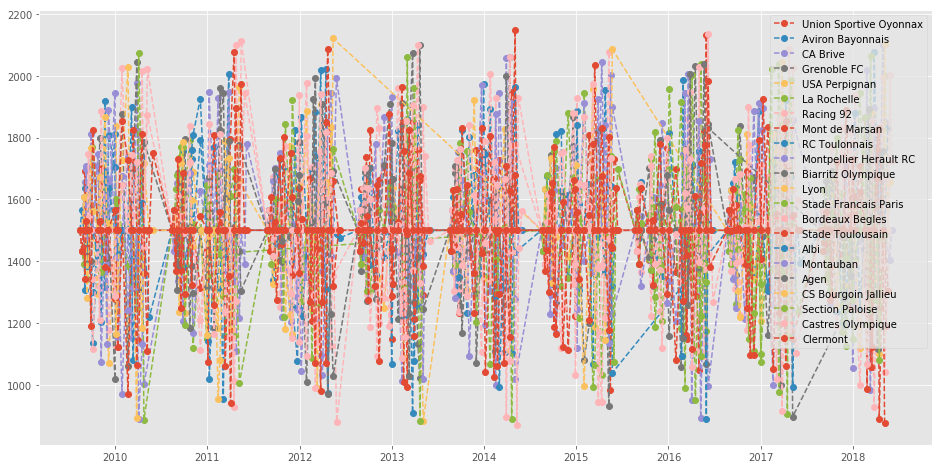

In [12]:
plot_glicko(df_with_ratings)

In [13]:
pylab.rcParams['figure.figsize'] = (16.0, 8.0)

In [14]:
tmp = df_with_ratings[df_with_ratings["season"] == 2016].sort_values("season_order")

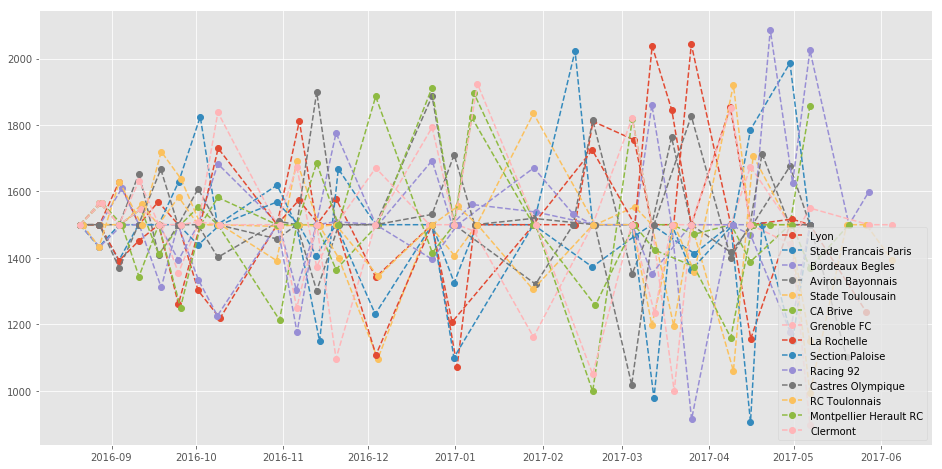

In [15]:
plot_glicko(tmp)